In [1]:
import csv
import math

import matplotlib.pyplot as plt
%matplotlib inline

import pyproj

In [2]:
station_latlondes = {}
with open('ghcnd-stations.txt') as f:
    for line in f:
        line = line.split()
        station_latlondes[line[0]] = [float(line[1]), float(line[2]), ' '.join(line[4:])]

In [3]:
# Using Winkel-Triple projection
# which is what National Geographic uses
# according to https://www.geoawesomeness.com/best-map-projection/

In [4]:
# Following: https://pyproj4.github.io/pyproj/stable/gotchas.html#proj-not-a-generic-latitude-longitude-to-projection-converter
crs_4326 = pyproj.CRS('WGS84')
# Name as in: https://proj.org/operations/projections/wintri.html
crs_proj = pyproj.CRS('+proj=wintri')
transformer = pyproj.Transformer.from_crs(crs_4326, crs_proj)

In [5]:
station_xydes = {}
for station, latlondes in station_latlondes.items():
    xy = transformer.transform(latlondes[0], latlondes[1])
    station_xydes[station] = [xy[0], xy[1], latlondes[2]]

In [6]:
#           0/1     1/2  2/3     3/4   4/5              5/6          6/7
# format is station,date,measure,value,measurement flag,quality flag,source flag

In [7]:
all_prcp = []

with open('201X_PRCP.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        if line[5] != '':
            continue  # skip quality problems
        value = int(line[3])  # tenths of mm
        all_prcp.append(value)

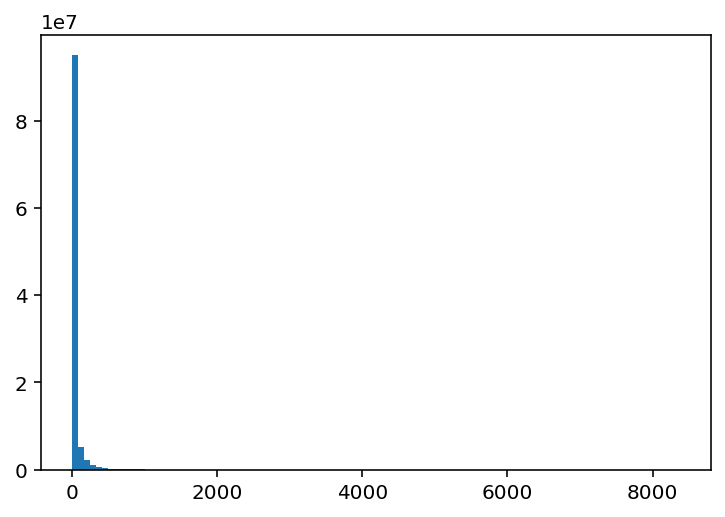

In [8]:
_ = plt.hist(all_prcp, bins=100)

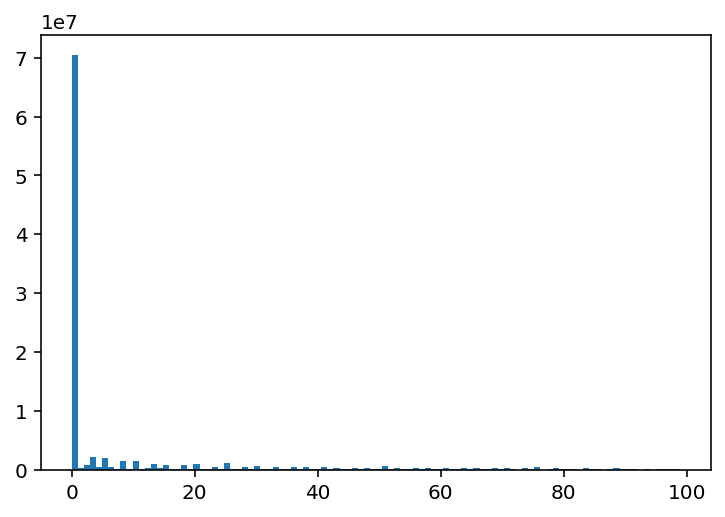

In [9]:
# Just values less than a centimeter
_ = plt.hist([value for value in all_prcp if value < 100], bins=100)

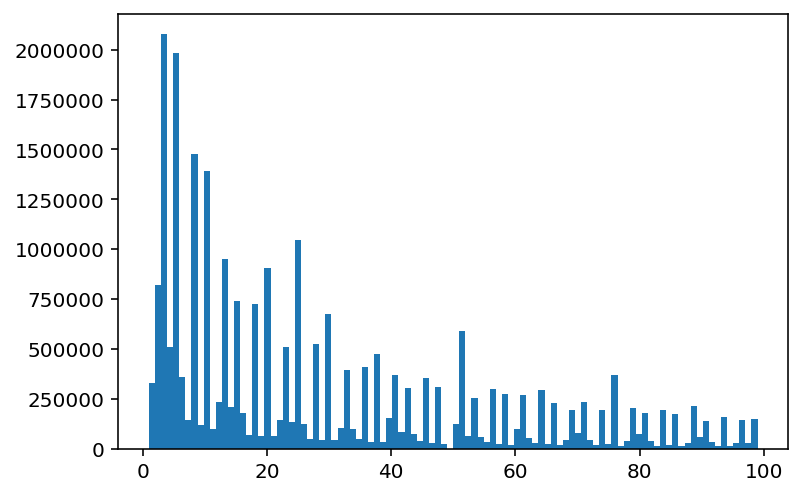

In [10]:
# Just values > 0 and less than a centimeter
_ = plt.hist([value for value in all_prcp if 0 < value < 100], bins=100)

In [11]:
# According to https://weatherins.com/rain-guidelines/
# a quarter-inch of rain is substantial,
# which is 64 tenths of a mm.
# So let's say, I don't know, maybe 1 mm doesn't count as rain yet.

In [12]:
del all_prcp

In [13]:
# Precipitation
station_prcp = {}

with open('201X_PRCP.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        if line[5] != '':
            continue  # skip quality problems
        value = int(line[3])  # tenths of mm
        station_prcp.setdefault(line[0], []).append(value)

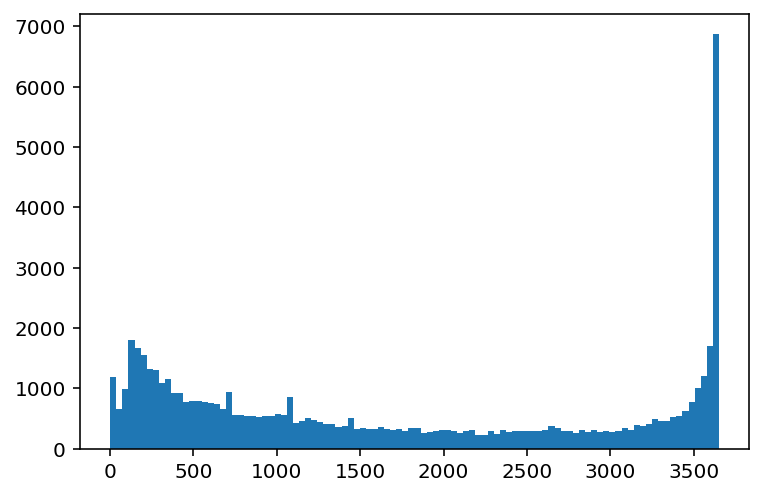

In [14]:
_ = plt.hist([len(values) for values in station_prcp.values()], bins=100)
# Some stations report more than once per day, but let's ignore that.

In [15]:
min_count = 500

In [16]:
print('total stations')
print(len(station_prcp))
low_stations = [station for station, values in station_prcp.items()
                if len(values) < min_count]
print('low-data stations')
print(len(low_stations))

total stations
60504
low-data stations
15841


In [17]:
for station in low_stations:
    del station_prcp[station]

print('remaining')
print(len(station_prcp))

remaining
44663


In [18]:
# Rate of more than 1 mm precipitation measurements
station_prcp_rate = {station: sum(value > 10 for value in values) / len(values)
                     for station, values in station_prcp.items()}

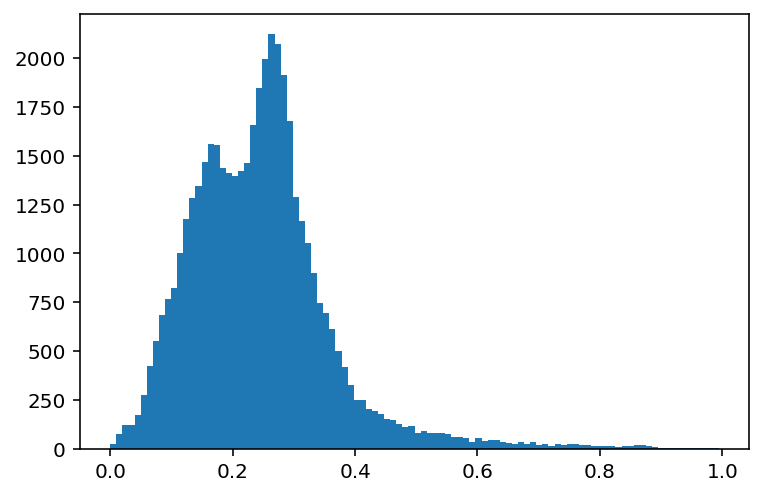

In [19]:
_ = plt.hist(list(station_prcp_rate.values()), bins=100)

In [20]:
del station_prcp

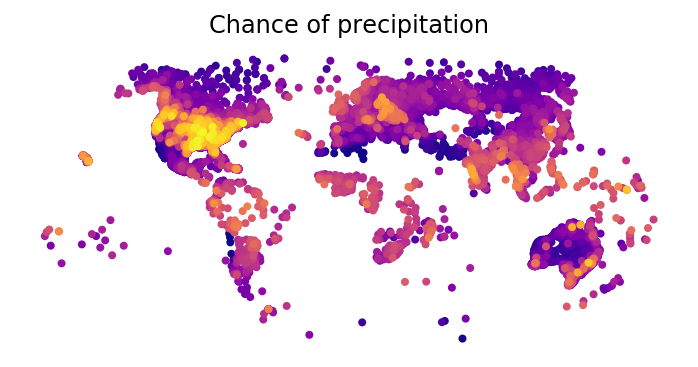

In [135]:
results = list(station_prcp_rate.items())
results.sort(key=lambda line: line[1])  # high-precipitation places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[line[1] for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Chance of precipitation')
_ = plt.axis('off')
plt.savefig('chance_of_precipitation.png', dpi=200, bbox_inches='tight', facecolor='#DCDCCC')

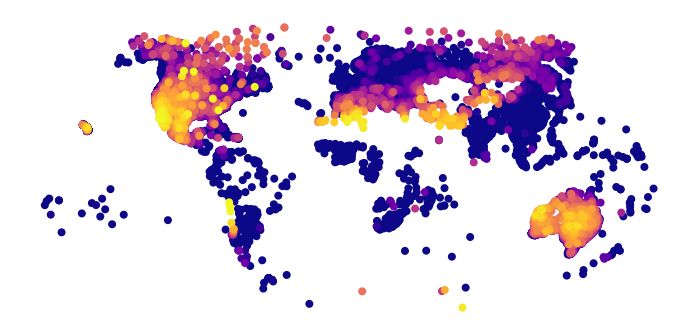

In [49]:
# NOT TOO WET
results = list(station_prcp_rate.items())
results.sort(key=lambda line: -line[1])  # low-precipitation places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[1 - line[1] if line[1] < 0.25 else 0.75 for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
_ = plt.axis('off')

In [50]:
# Min temperature
station_tmin = {}

with open('201X_TMIN.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        if line[5] != '':
            continue  # skip quality problems
        value = int(line[3])  # tenths of degree Celsius
        station_tmin.setdefault(line[0], []).append(value)

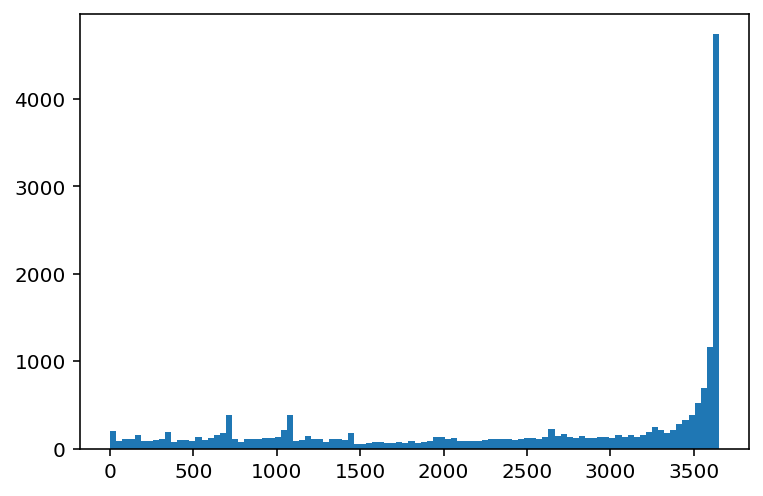

In [51]:
_ = plt.hist([len(values) for values in station_tmin.values()], bins=100)

In [52]:
print('total stations')
print(len(station_tmin))
low_stations = [station for station, values in station_tmin.items()
                if len(values) < min_count]
print('low-data stations')
print(len(low_stations))

total stations
19725
low-data stations
1578


In [53]:
for station in low_stations:
    del station_tmin[station]

print('remaining')
print(len(station_tmin))

remaining
18147


In [54]:
# Rate of min temp less than zero
station_cold_rate = {station: sum(value < 0 for value in values) / len(values)
                     for station, values in station_tmin.items()}

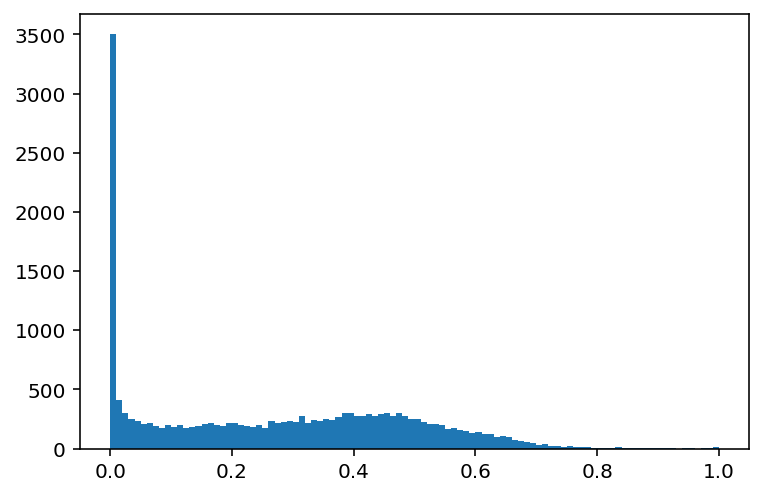

In [55]:
_ = plt.hist(list(station_cold_rate.values()), bins=100)

In [56]:
del station_tmin

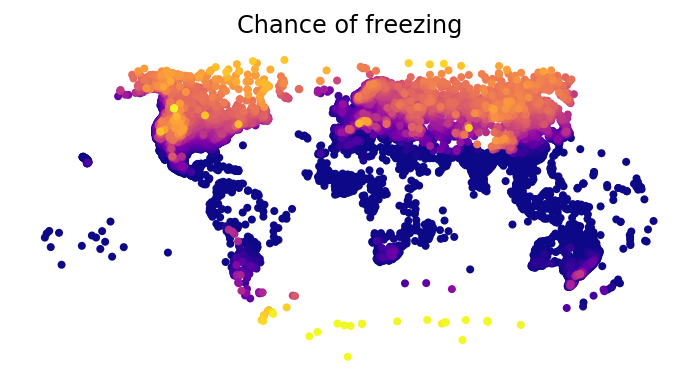

In [136]:
results = list(station_cold_rate.items())
results.sort(key=lambda line: line[1])  # cold places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[line[1] for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Chance of freezing')
_ = plt.axis('off')
plt.savefig('chance_of_freezing.png', dpi=200, bbox_inches='tight', facecolor='#DCDCCC')

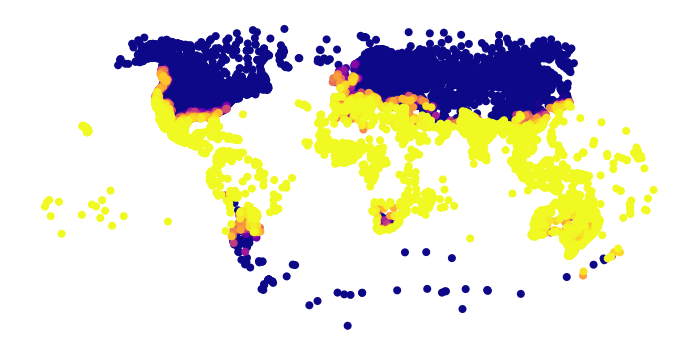

In [61]:
# NOT TOO COLD
results = list(station_cold_rate.items())
results.sort(key=lambda line: -line[1])  # not-cold places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[1 - line[1] if line[1] < 1/12 else 11/12 for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
_ = plt.axis('off')

In [59]:
# Max temperature
station_tmax = {}

with open('201X_TMAX.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        if line[5] != '':
            continue  # skip quality problems
        value = int(line[3])  # tenths of degree Celsius
        station_tmax.setdefault(line[0], []).append(value)

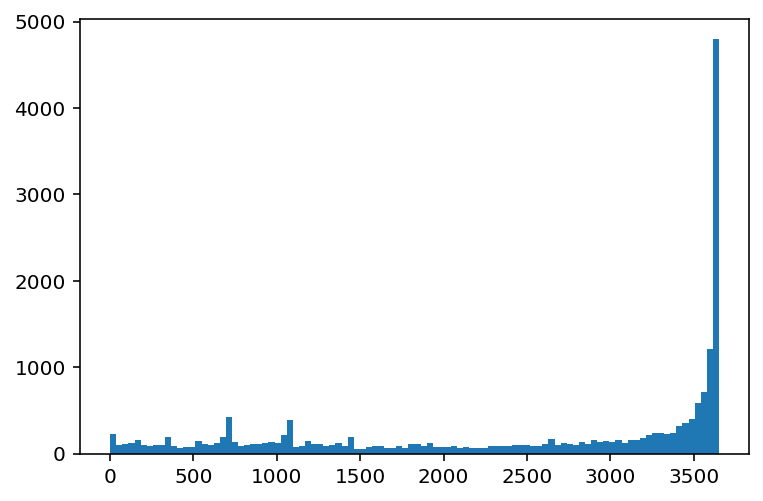

In [62]:
_ = plt.hist([len(values) for values in station_tmax.values()], bins=100)

In [63]:
print('total stations')
print(len(station_tmax))
low_stations = [station for station, values in station_tmax.items()
                if len(values) < min_count]
print('low-data stations')
print(len(low_stations))

total stations
19717
low-data stations
1555


In [64]:
for station in low_stations:
    del station_tmax[station]

print('remaining')
print(len(station_tmax))

remaining
18162


In [65]:
# Rate of max temp greater than 30
station_hot_rate = {station: sum(value > 270 for value in values) / len(values)
                     for station, values in station_tmax.items()}

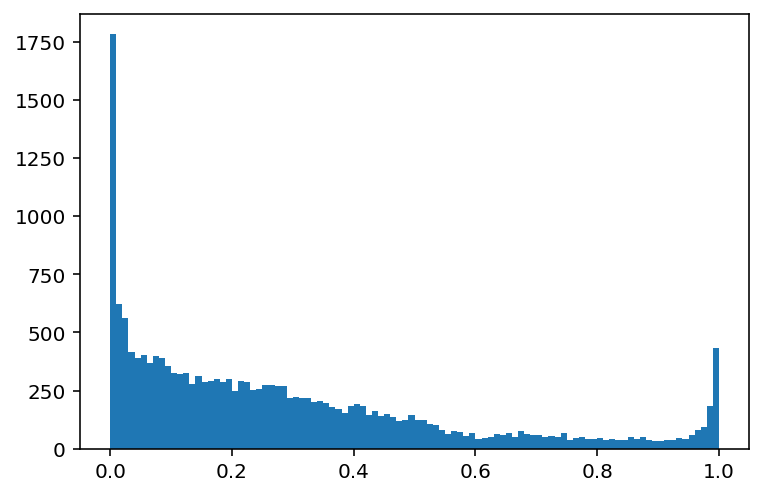

In [66]:
_ = plt.hist(list(station_hot_rate.values()), bins=100)

In [46]:
del station_tmax

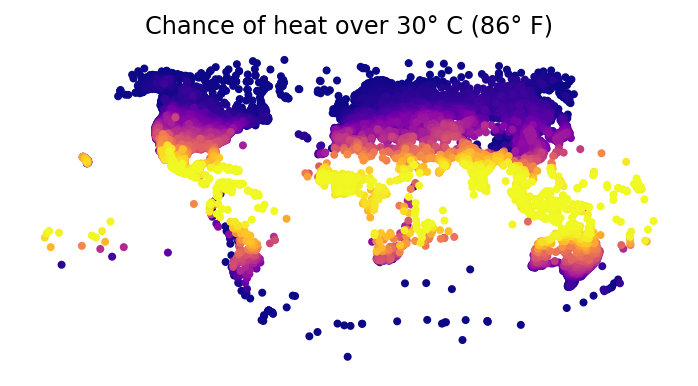

In [137]:
results = list(station_hot_rate.items())
results.sort(key=lambda line: line[1])  # hot places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[line[1] for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Chance of heat over 30° C (86° F)')
_ = plt.axis('off')
plt.savefig('chance_of_heat.png', dpi=200, bbox_inches='tight', facecolor='#DCDCCC')

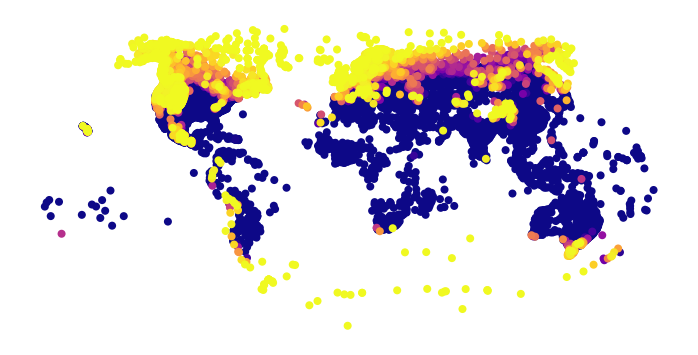

In [69]:
# NOT TOO HOT
results = list(station_hot_rate.items())
results.sort(key=lambda line: -line[1])  # not-hot places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[1 - line[1] if line[1] < 1/12 else 11/12 for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
_ = plt.axis('off')

In [123]:
# Maybe I'm trying to keep it too dry...
def score_for_prcp_rate(number):
    if number < 1/9:
        return 1/9 - number
    if number > 1/6:
        return number - 1/6
    return 0

station_bad_score = {}
for station, prcp_rate in station_prcp_rate.items():
    if station in station_cold_rate and station in station_hot_rate:
        prcp_score = score_for_prcp_rate(prcp_rate)
        cold_rate = station_cold_rate[station]
        hot_rate = station_hot_rate[station]
        station_bad_score[station] = prcp_score + cold_rate + hot_rate

In [143]:
len(station_bad_score)

15686

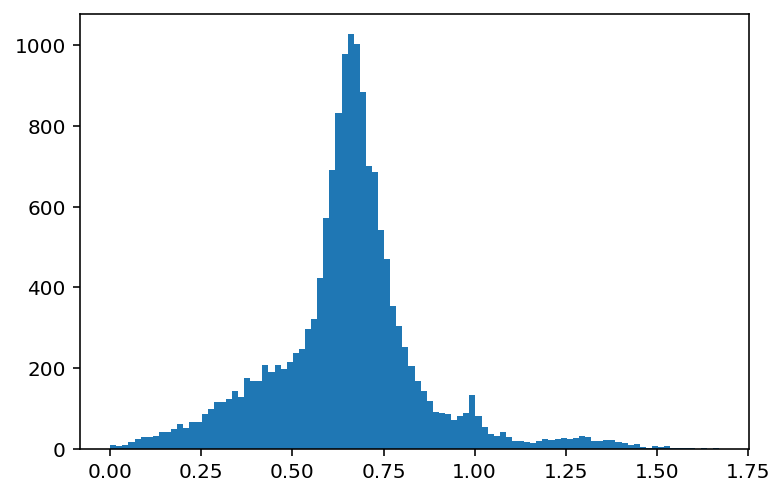

In [124]:
_ = plt.hist(list(station_bad_score.values()), bins=100)

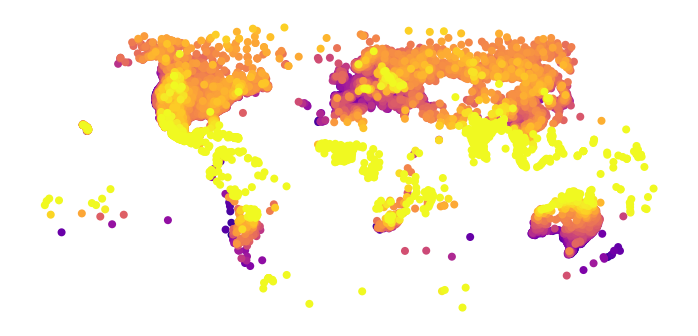

In [125]:
results = list(station_bad_score.items())
results.sort(key=lambda line: line[1])  # bad places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[min(line[1], 1) for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
_ = plt.axis('off')

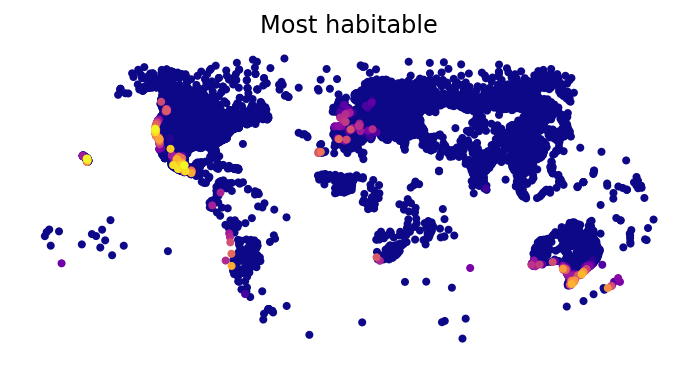

In [138]:
# NOT TOO BAD
results = list(station_bad_score.items())
results.sort(key=lambda line: -line[1])  # not-bad places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[1 - line[1] if line[1] < 0.25 else 0.75 for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Most habitable')
_ = plt.axis('off')
plt.savefig('most_habitable.png', dpi=200, bbox_inches='tight', facecolor='#DCDCCC')

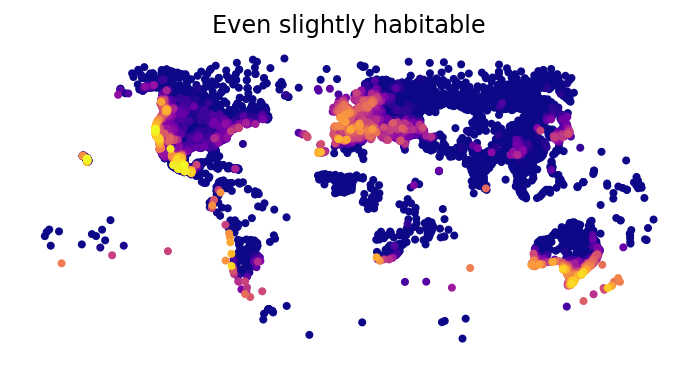

In [145]:
# NOT TOO BAD (BUT NOT NECESSARILY GREAT)
results = list(station_bad_score.items())
results.sort(key=lambda line: -line[1])  # not-bad places last
plt.scatter([station_xydes[line[0]][0] for line in results],
            [station_xydes[line[0]][1] for line in results],
            c=[1 - line[1] if line[1] < 0.6 else 0.4 for line in results],
            marker='.', cmap='plasma')
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Even slightly habitable')
_ = plt.axis('off')
plt.savefig('even_slightly_habitable.png', dpi=200, bbox_inches='tight', facecolor='#DCDCCC')

In [128]:
for result in results[-30:]:
    print(result)
    print(station_latlondes[result[0]])

('USC00046377', 0.05662033625884881)
[33.2097, -117.395, 'CA OCEANSIDE MARINA']
('MXN00011141', 0.05615942028985507)
[21.1667, -101.2333, 'CIENEGA DE NEGROS']
('USC00047741', 0.05362981281485464)
[32.7653, -117.2314, 'CA SAN DIEGO SEAWORLD']
('MXN00007333', 0.0516348450995754)
[15.3167, -92.2667, 'BUENOS AIRES']
('USW00023234', 0.05148678414096916)
[37.6197, -122.3647, 'CA SAN FRANCISCO INTL AP 72494']
('CIM00085682', 0.04582961665961379)
[-36.773, -73.063, 'CARRIEL SUR INTL 85682']
('MXN00013065', 0.04505582137161085)
[20.8667, -99.2, 'ENCARNACION']
('USC00043191', 0.04335692647038294)
[38.515, -123.2447, 'CA FT ROSS']
('MXN00032031', 0.04272472169875019)
[22.7667, -102.5667, 'LA BUFA (OBS)']
('ASN00092124', 0.04253057306679642)
[-42.6619, 148.0181, 'MARIA ISLAND (POINT LESUEUR) 95988']
('ASN00069137', 0.03986775462469947)
[-37.2622, 150.0504, 'GREEN CAPE AWS 94934']
('MXN00013128', 0.0351859528824751)
[20.1167, -98.8833, 'SAN AGUSTIN TLAXIACA OCAVM']
('USC00045795', 0.034753150257551